### Importing Necessary Libraries

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Loading Data

In [87]:
bangle_data = pd.read_csv("../HRV106M/HRV106M_Finger_Physical Stress/bangle.csv")
bangle_data.head()

,timestamp_ms,value
0,1729021816410,3310
1,1729021816428,3310
2,1729021816449,3310
3,1729021816471,3306
4,1729021816493,3294


### Normalizing Timestamps and Plotting Raw Data

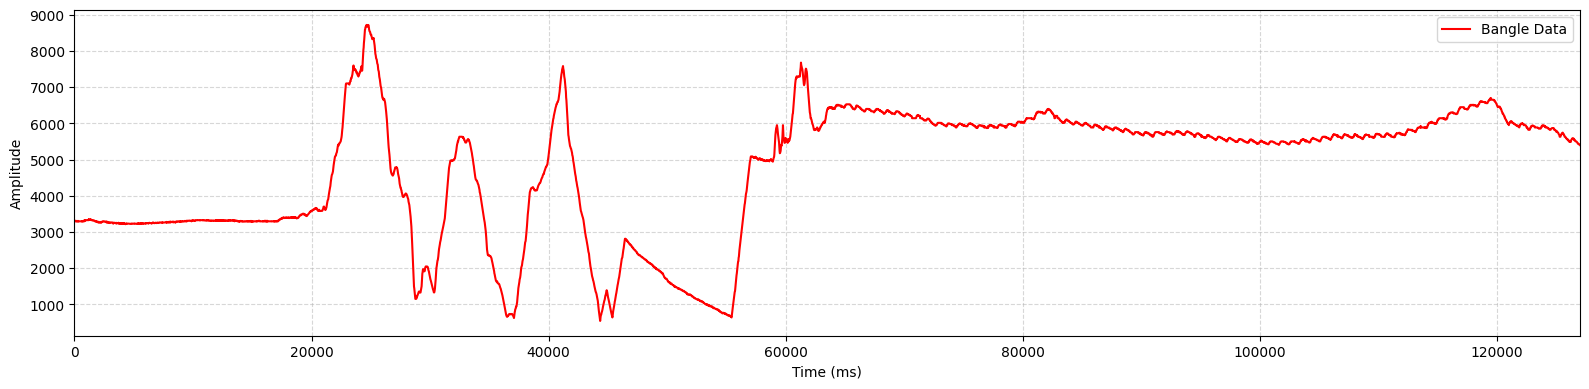

In [88]:
timestamps = bangle_data["timestamp_ms"].to_numpy()
ppg_raw = bangle_data["value"].to_numpy()

' Normalizing timestamp (ms), such that it starts from 0 ms'
t0 = bangle_data["timestamp_ms"].iloc[0]
timestamps = timestamps - t0

plt.figure(figsize=(16, 4))
plt.plot(timestamps, ppg_raw, c='r', label="Bangle Data")
plt.grid(which='both', axis='both', linestyle='--', alpha=0.5)
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.legend()
plt.xlim(left=0, right=127000)
plt.tight_layout()
plt.show()

### Filtering With Old Method and Plotting Filtered Data

Estimated PPG sampling rate: 41.5 Hz


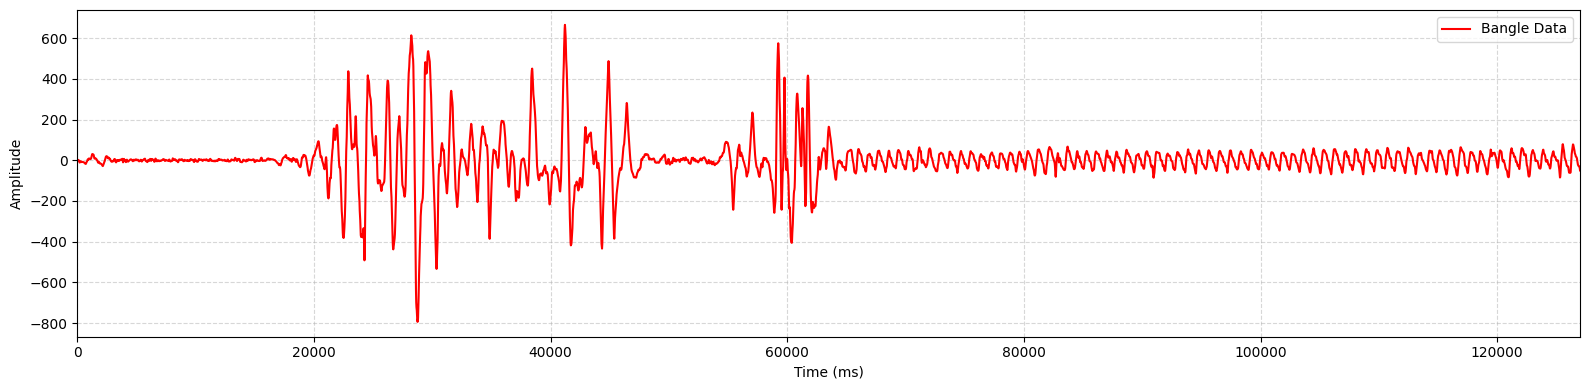

In [89]:
dt = np.diff(timestamps) / 1000.0
fs = 1 / np.mean(dt)
print(f"Estimated PPG sampling rate: {fs:.1f} Hz")

from scipy.signal import butter

lowcut, highcut = 0.5, 8.0
nyq = 0.5 * fs
b, a = butter(3, [lowcut/nyq, highcut/nyq], btype='band')

from scipy.signal import filtfilt

ppg_filt = filtfilt(b, a, ppg_raw)

plt.figure(figsize=(16, 4))
plt.plot(timestamps, ppg_filt, c='r', label="Bangle Data")
plt.grid(which='both', axis='both', linestyle='--', alpha=0.5)
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.legend()
plt.xlim(left=0, right=127000)
plt.tight_layout()
plt.show()

### Finding Peaks With Old Method

Detected 179 peaks in the Filtered PPG


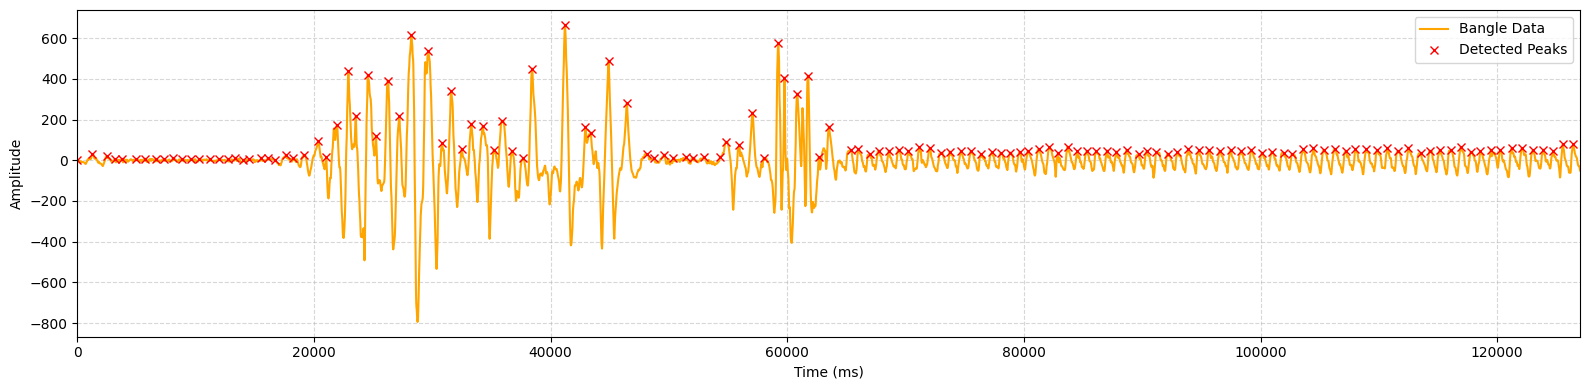

In [90]:
from scipy.signal import find_peaks

min_dist = int(0.5 * fs)
peaks, props = find_peaks(ppg_filt, distance=min_dist, height=np.mean(ppg_filt))

print(f"Detected {len(peaks)} peaks in the Filtered PPG")

plt.figure(figsize=(16, 4))
plt.plot(timestamps, ppg_filt, c='orange', label="Bangle Data")
plt.plot(timestamps[peaks], ppg_filt[peaks], 'x', c='red', label="Detected Peaks")
plt.grid(which='both', axis='both', linestyle='--', alpha=0.5)
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.legend()
plt.xlim(left=0, right=127000)
plt.tight_layout()
plt.show()

### New Method